# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План работы**

1. **Загрузим данные и проведем их предварительную обработку.**  
2. **Обучим несколько моделей.**  
   Для каждой модели подберем оптимальные значения гиперпараметров.  
3. **Оценим производительность моделей, сравнив их скорость работы и качество.**  

---

**Описание данных**

**Признаки:**
- **DateCrawled** — дата скачивания анкеты из базы  
- **VehicleType** — тип автомобильного кузова  
- **RegistrationYear** — год регистрации автомобиля  
- **Gearbox** — тип коробки передач  
- **Power** — мощность (л. с.)  
- **Model** — модель автомобиля  
- **Kilometer** — пробег (км)  
- **RegistrationMonth** — месяц регистрации автомобиля  
- **FuelType** — тип топлива  
- **Brand** — марка автомобиля  
- **Repaired** — была машина в ремонте или нет  
- **DateCreated** — дата создания анкеты  
- **NumberOfPictures** — количество фотографий автомобиля  
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)  
- **LastSeen** — дата последней активности пользователя  

**Целевой признак:**
- **Price** — цена (евро)  

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

In [3]:
!pip install lightgbm -q

In [4]:
!pip install -U scikit-learn -q

In [5]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer

In [6]:
autos = pd.read_csv('/datasets/autos.csv')
styled_autos = autos.head(10).style.background_gradient(cmap='Blues', axis=1)
display(styled_autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,nan,1993,manual,0,golf,150000,0,petrol,volkswagen,nan,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,nan,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,nan,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,nan,volkswagen,nan,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Мы загрузили данные сервиса по продаже подержанных автомобилей «Не бит, не крашен» и теперь проведем их анализ.

In [7]:
print("Информация о данных:")
autos.info()
print("\nОписательная статистика:")
display(autos.describe())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtyp

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
def plot_chart(data, chart_type, column, title, xlabel, ylabel, bins=10, color='skyblue', figsize=(12, 6), **kwargs):
    if chart_type == 'hist':
        ax = data[column].plot(kind='hist', bins=bins, grid=False, color=color, figsize=figsize, **kwargs)
    elif chart_type == 'line':
        ax = data[column].plot(kind='line', color=color, figsize=figsize, **kwargs)
    elif chart_type == 'bar':
        ax = data[column].plot(kind='bar', color=color, figsize=figsize, **kwargs)
    elif chart_type == 'scatter':
        ax = data.plot(kind='scatter', x=column[0], y=column[1], color=color, figsize=figsize, **kwargs)
    else:
        raise ValueError("Unsupported chart type")

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7, color='gray')
    plt.tight_layout()
    plt.show()

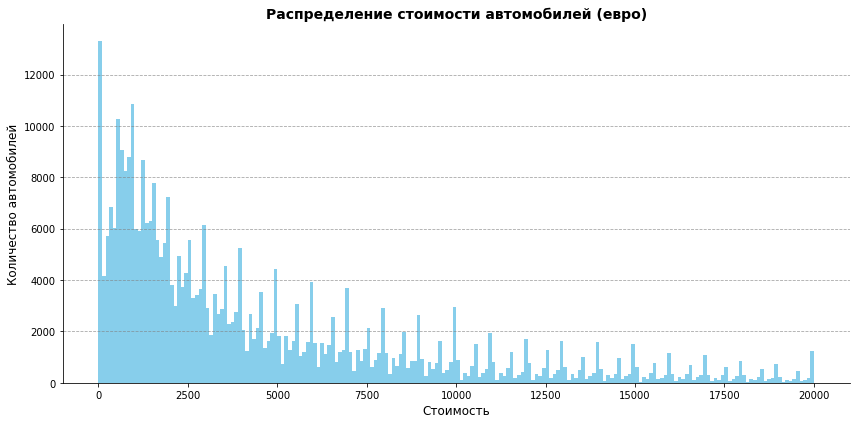

In [10]:
file = autos
column = 'Price'
title = 'Распределение стоимости автомобилей (евро)'
xlabel = 'Стоимость'
ylabel = 'Количество автомобилей'
bins = 200
plot_chart(file, chart_type='hist', column=column, title=title, xlabel=xlabel, ylabel=ylabel, bins=bins)

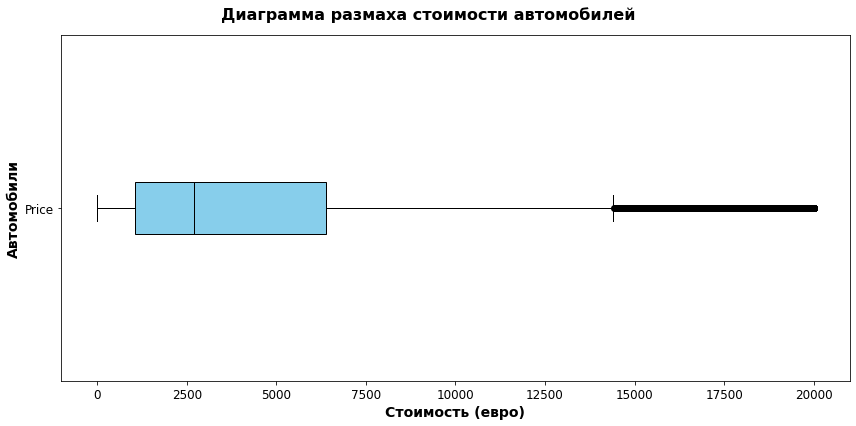

In [11]:
fig, axes = plt.subplots(figsize=(12, 6))
autos.boxplot(column=['Price'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', edgecolor='black'), 
              grid=False, fontsize=12, color='black')

plt.suptitle('Диаграмма размаха стоимости автомобилей', fontsize=16, fontweight="bold", color='black')
plt.xlabel('Стоимость (евро)', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Автомобили', fontsize=14, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

Наблюдаются выбросы в данных о стоимости автомобилей, поэтому мы исключим значения, находящиеся ниже 5-го и выше 95-го перцентилей.

In [12]:
autos['Price'].quantile([0.05, 0.95])

0.05      200.0
0.95    14600.0
Name: Price, dtype: float64

In [13]:
autos = autos.query('200 <= Price <= 14600')

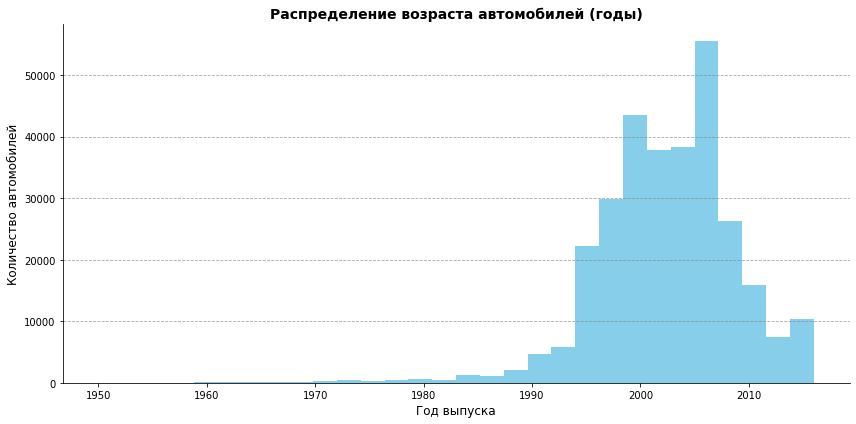

In [15]:
file = autos[(autos['RegistrationYear'] >= 1950) & (autos['RegistrationYear'] <= 2016)]
column = 'RegistrationYear'
title = 'Распределение возраста автомобилей (годы)'
xlabel = 'Год выпуска'
ylabel = 'Количество автомобилей'
bins = 30

plot_chart(file, chart_type='hist', column=column, title=title, xlabel=xlabel, ylabel=ylabel, bins=bins)

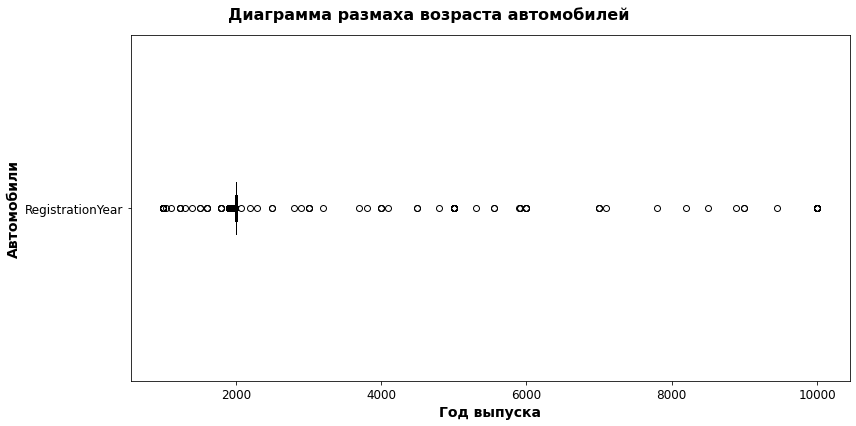

In [16]:
fig, axes = plt.subplots(figsize=(12, 6))
autos.boxplot(column=['RegistrationYear'], vert=False, patch_artist=True, 
              boxprops=dict(facecolor='skyblue', edgecolor='black'), 
              grid=False, fontsize=12, color='black')

plt.suptitle('Диаграмма размаха возраста автомобилей', fontsize=16, fontweight="bold", color='black')
plt.xlabel('Год выпуска', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Автомобили', fontsize=14, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

Наблюдаются выбросы в данных о возрасте автомобилей, поэтому мы исключим значения ниже 5-го и выше 95-го перцентилей.

In [17]:
autos['RegistrationYear'].quantile([0.05, 0.95])

0.05    1993.0
0.95    2016.0
Name: RegistrationYear, dtype: float64

In [18]:
autos = autos.query('1970 <= RegistrationYear <= 2016')

In [19]:
print(*autos['VehicleType'].unique(), sep='\n')

nan
suv
small
sedan
convertible
bus
wagon
coupe
other


In [20]:
autos['VehicleType'] = autos['VehicleType'].fillna('unknown')

In [21]:
print(*autos['VehicleType'].unique(), sep='\n')

unknown
suv
small
sedan
convertible
bus
wagon
coupe
other


Обнаружены пропуски в данных о типе кузова автомобилей (VehicleType). Пропуски были заполнены категорией «unknown», чтобы избежать искажения данных, учитывая различия в типах кузова и ценах для автомобилей одного бренда.

In [22]:
spisok = autos['Brand'].unique()
for element in spisok:
    most_common_type = autos.loc[autos['Brand'] == element, 'VehicleType'].mode()[0]
    print(element, ' - ', most_common_type)
    autos.loc[(autos['Brand'] == element) & (autos['VehicleType'].isna()), 'VehicleType'] = most_common_type

volkswagen  -  sedan
jeep  -  suv
skoda  -  wagon
bmw  -  sedan
peugeot  -  small
ford  -  small
mazda  -  sedan
renault  -  small
mercedes_benz  -  sedan
seat  -  small
honda  -  sedan
fiat  -  small
opel  -  small
mini  -  small
smart  -  small
hyundai  -  small
audi  -  sedan
nissan  -  small
alfa_romeo  -  sedan
subaru  -  wagon
volvo  -  wagon
mitsubishi  -  sedan
kia  -  small
suzuki  -  small
lancia  -  small
citroen  -  small
sonstige_autos  -  unknown
toyota  -  small
chevrolet  -  small
dacia  -  wagon
daihatsu  -  small
chrysler  -  bus
jaguar  -  sedan
daewoo  -  small
rover  -  sedan
porsche  -  convertible
saab  -  sedan
trabant  -  sedan
land_rover  -  suv
lada  -  suv


In [23]:
autos['VehicleType'].isnull().sum()

0

In [24]:
display(autos.loc[autos['Brand'] == 'sonstige_autos'])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
306,2016-03-21 14:38:37,200,unknown,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20 00:00:00,0,90562,2016-04-03 04:17:08
661,2016-04-01 15:56:27,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no,2016-04-01 00:00:00,0,17309,2016-04-07 14:56:03
700,2016-03-30 21:37:21,6999,sedan,2010,auto,186,NaN,125000,4,petrol,sonstige_autos,no,2016-03-30 00:00:00,0,81929,2016-04-05 11:18:33
985,2016-03-15 16:37:22,500,sedan,2010,manual,101,NaN,70000,1,petrol,sonstige_autos,yes,2016-03-15 00:00:00,0,76829,2016-03-21 14:15:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353892,2016-03-06 11:42:12,7900,bus,2009,NaN,140,NaN,125000,7,gasoline,sonstige_autos,no,2016-03-06 00:00:00,0,97256,2016-03-26 16:16:02
354062,2016-03-19 11:25:16,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no,2016-03-19 00:00:00,0,63069,2016-04-07 00:46:42
354073,2016-03-19 14:53:26,1750,unknown,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN,2016-03-19 00:00:00,0,6188,2016-04-01 01:47:17
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15 00:00:00,0,91186,2016-03-17 08:16:25


In [25]:
df = autos.loc[autos['Brand'] == 'sonstige_autos']
print(*df['Model'].unique(), sep='\n')

nan


В данных для бренда Brand, где указано "sonstige_autos" (другие автомобили), отсутствует информация о модели автомобиля Model. Мы заполним это пустое значение меткой "no_info".

In [26]:
autos.loc[autos['Brand'] == 'sonstige_autos', 'Model'] = 'no_info'

In [27]:
autos['Model'] = autos['Model'].fillna('unknown')

In [28]:
print(*autos['Model'].unique(), sep='\n')

golf
grand
fabia
3er
2_reihe
c_max
3_reihe
passat
polo
twingo
a_klasse
scirocco
5er
arosa
other
civic
transporter
punto
e_klasse
clio
kadett
kangoo
one
fortwo
1er
b_klasse
signum
astra
a8
jetta
fiesta
c_klasse
micra
vito
sprinter
156
unknown
escort
forester
xc_reihe
scenic
a4
ka
a1
insignia
combo
focus
tt
corsa
a6
jazz
omega
slk
7er
80
147
z_reihe
sorento
v40
ibiza
eos
touran
getz
a3
almera
megane
lupo
r19
caddy
mondeo
cordoba
colt
impreza
vectra
berlingo
tiguan
sharan
6_reihe
no_info
c4
panda
up
i_reihe
ceed
yeti
octavia
zafira
mii
rx_reihe
modus
fox
matiz
beetle
c1
rio
logan
spider
cuore
s_max
a2
c3
1_reihe
avensis
viano
roomster
sl
kaefer
santa
cooper
leon
4_reihe
sportage
laguna
ptcruiser
clk
primera
espace
galaxy
s_klasse
159
transit
juke
x_reihe
qashqai
carisma
accord
corolla
lanos
phaeton
verso
swift
rav
picanto
boxster
kalos
stilo
alhambra
touareg
roadster
ypsilon
galant
justy
90
sirion
crossfire
agila
duster
v50
mx_reihe
500
meriva
c_reihe
v_klasse
m_klasse
yaris
c5
aygo
cc
ca

In [29]:
brand_counts = autos['Brand'].value_counts()

print(brand_counts)

volkswagen        65791
opel              34907
bmw               31284
mercedes_benz     27277
audi              24535
ford              21796
renault           15694
peugeot           10065
fiat               8462
seat               6019
mazda              5032
skoda              4935
smart              4918
citroen            4605
nissan             4244
toyota             4231
hyundai            3178
volvo              2826
mitsubishi         2673
mini               2556
honda              2518
kia                2127
suzuki             2111
alfa_romeo         2045
sonstige_autos     2029
chevrolet          1520
chrysler           1257
dacia               845
daihatsu            704
subaru              652
jeep                540
saab                485
daewoo              484
porsche             434
land_rover          421
jaguar              416
rover               414
lancia              411
trabant             400
lada                205
Name: Brand, dtype: int64


Обнаружены пропуски в данных о моделях автомобилей (Model). Пропуски были заполнены категорией «unknown», чтобы избежать искажения данных, учитывая разнообразие моделей для каждого бренда

In [30]:
for element in autos['Brand'].unique():
    most_common_model = autos.loc[autos['Brand'] == element, 'Model'].mode()[0]
    print(f'{element} - {most_common_model}')
    autos.loc[(autos['Brand'] == element) & (autos['Model'].isna()), 'Model'] = most_common_model

volkswagen - golf
jeep - grand
skoda - fabia
bmw - 3er
peugeot - 2_reihe
ford - focus
mazda - 6_reihe
renault - twingo
mercedes_benz - c_klasse
seat - ibiza
honda - civic
fiat - punto
opel - corsa
mini - cooper
smart - fortwo
hyundai - i_reihe
audi - a4
nissan - micra
alfa_romeo - 156
subaru - impreza
volvo - v40
mitsubishi - colt
kia - other
suzuki - other
lancia - ypsilon
citroen - other
sonstige_autos - no_info
toyota - yaris
chevrolet - other
dacia - logan
daihatsu - cuore
chrysler - other
jaguar - x_type
daewoo - matiz
rover - other
porsche - cayenne
saab - other
trabant - 601
land_rover - freelander
lada - niva


In [31]:
autos['Model'].isnull().sum()

0

In [32]:
print(*autos['Gearbox'].unique(), sep='\n')

manual
auto
nan


В данных о типе коробки передач (Gearbox) имеются пропуски. Эти значения мы заполним меткой "no_info".

In [33]:
autos['Gearbox'] = autos['Gearbox'].fillna('no_info')

In [34]:
print(*autos['FuelType'].unique(), sep='\n')

petrol
gasoline
nan
lpg
other
hybrid
cng
electric


В данных о типе топлива (FuelType) имеются пропуски. Эти значения будут заменены на "no_info".

In [35]:
autos['FuelType'] = autos['FuelType'].fillna('no_info')

In [36]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             55148
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [37]:
print(*autos['Repaired'].unique(), sep='\n')

nan
no
yes


В данных о ремонте автомобиля (Repaired) есть пропуски. Эти значения мы заполним меткой "no_info".

In [38]:
autos['Repaired'] = autos['Repaired'].fillna('no_info')
print(*autos['Repaired'].unique(), sep='\n')

no_info
no
yes


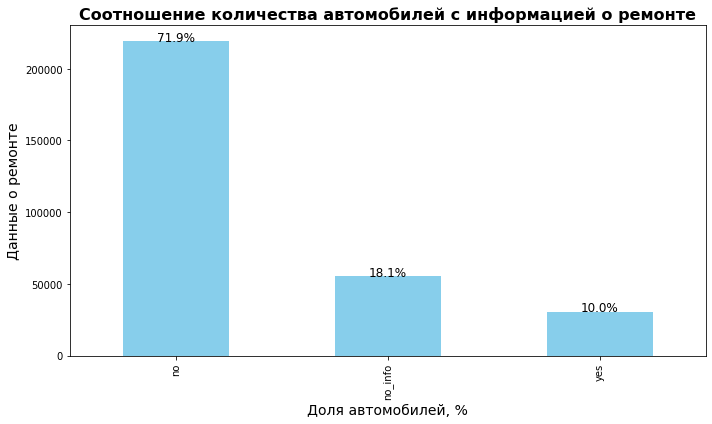

In [39]:
file = autos
column = 'Repaired'
title = 'Соотношение количества автомобилей с информацией о ремонте'
xlabel = 'Доля автомобилей, %'
ylabel = 'Данные о ремонте'

file[column].fillna('no_info', inplace=True)
repaired_counts = file[column].value_counts()
repaired_percentage = repaired_counts / repaired_counts.sum() * 100

ax = repaired_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))

for i, v in enumerate(repaired_counts):
    ax.text(i, v + 0.5, f'{repaired_percentage[i]:.1f}%', ha='center', fontsize=12)

ax.set_title(title, fontsize=16, fontweight="bold")
ax.set_xlabel(xlabel, fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)

plt.tight_layout()
plt.show()

In [40]:
autos.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [41]:
autos.duplicated().sum()

4

In [42]:
autos[autos.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Найдены дубликаты в данных. Удалим их.

In [43]:
autos = autos.drop_duplicates()
autos.duplicated().sum()

0

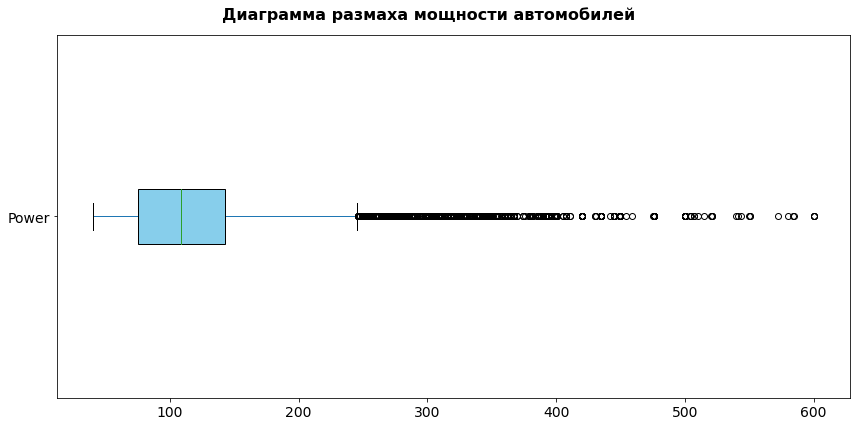

In [47]:
#Заменю ограничение по мощности, устанавлю нижнюю границу в 40 л.с.
autos = autos.query('40 <= Power <= 600')  # 600 л.с. как верхняя граница для внедорожников

#Диаграмма размаха мощности автомобилей.
fig, axes = plt.subplots(figsize=(12, 6))
autos.boxplot(column=['Power'], vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"), grid=False, fontsize=14)
plt.suptitle(f'Диаграмма размаха мощности автомобилей', fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

In [48]:
autos['Power'].describe()

count    274247.000000
mean        117.693718
std          50.158042
min          40.000000
25%          75.000000
50%         109.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64

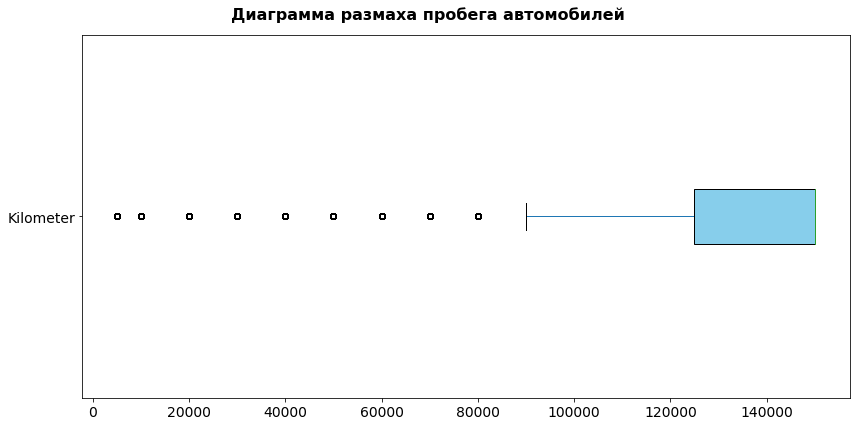

In [49]:
fig, axes = plt.subplots(figsize=(12, 6))
autos.boxplot(column=['Kilometer'], vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"), grid=False, fontsize=14)
plt.suptitle(f'Диаграмма размаха пробега автомобилей', fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

In [53]:
#Исключу категориальные признаки, такие как Brand и Model.
file = autos.loc[:, ['Price', 'RegistrationYear', 'Power', 'Kilometer']]

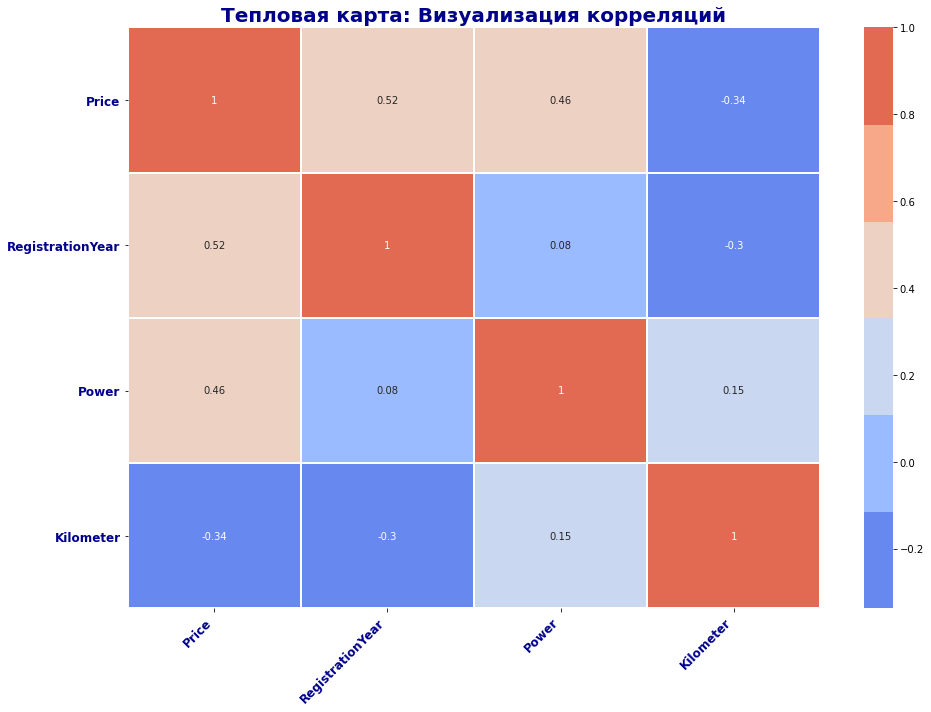

In [54]:
plt.figure(figsize=(14,10))
colormap = sns.color_palette("coolwarm")
chart = sns.heatmap(file.corr(), annot=True, cmap=colormap, linewidths=1, linecolor='white')
plt.title('Тепловая карта: Визуализация корреляций', fontsize=20, fontweight="bold", color='darkblue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12, fontweight="bold", color='darkblue')
chart.set_yticklabels(chart.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=12, fontweight="bold", color='darkblue')
plt.tight_layout()
plt.show()

Между ценой ("Price") и мощностью автомобиля ("Power") наблюдается умеренная положительная корреляция (значение 0.46), что указывает на то, что с увеличением цены увеличивается и мощность автомобиля.
Цена и год регистрации ("RegistrationYear") имеют слабую отрицательную корреляцию (-0.34), что предполагает, что чем позже был зарегистрирован автомобиль, тем выше его цена.
Мощность и год регистрации имеют слабые корреляции: положительную с "RegistrationYear" (0.08) и отрицательную с "Kilometer" (-0.3). Это говорит о том, что автомобили с большей мощностью обычно регистрируются раньше, но проходят меньший километраж.
Километраж и год регистрации также имеют слабую корреляцию: положительную с "RegistrationYear" (0.15) и отрицательную с "Power" (-0.15). Это означает, что автомобили, прошедшие больший километраж, обычно были зарегистрированы раньше, но обладают меньшей мощностью.

In [55]:
#Проверим уникальные значения для столбца типа топлива.
print(autos['FuelType'].unique())

['gasoline' 'petrol' 'no_info' 'lpg' 'other' 'hybrid' 'cng' 'electric']


**`gasoline`** на **`petrol`**- эти термины фактически означают одно и то же топливо—бензин. 

In [56]:
autos['FuelType'] = autos['FuelType'].replace({'gasoline': 'petrol'})

print(autos['FuelType'].unique())

['petrol' 'no_info' 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [57]:
#Проверим уникальные значения для модели.
print(autos['Model'].unique())

['grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat' 'polo'
 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other' 'civic'
 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one' 'fortwo' '1er'
 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter'
 '156' 'unknown' 'escort' 'forester' 'xc_reihe' 'scenic' 'ka' 'a1' 'focus'
 'a4' 'tt' 'astra' 'a6' 'jazz' 'omega' 'slk' '7er' 'combo' 'corsa' '80'
 '147' 'z_reihe' 'sorento' 'ibiza' 'eos' 'touran' 'getz' 'insignia'
 'almera' 'megane' 'a3' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda' 'up'
 'i_reihe' 'ceed' 'kangoo' 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe'
 'modus' 'fox' 'matiz' 'beetle' 'rio' 'logan' 'spider' 'cuore' 's_max'
 'a2' 'c3' '1_reihe' 'sharan' 'avensis' 'viano' 'roomster' 'sl' 'kaefer'
 'santa' 'leon' 'cooper' '4_reihe' 'sportage' 'laguna' 'ptcruiser' 'clk'
 'primera' 'espace' 'galaxy' 's_klasse' 'no_info' '159' 'transit' 'juke'
 'x_reih

In [58]:
autos['Model'] = autos['Model'].replace({
    'rangerover': 'range_rover',
    'range_rover_sport': 'range_rover',
    'no_info': 'unknown',
})

print(autos['Model'].unique())

['grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat' 'polo'
 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other' 'civic'
 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one' 'fortwo' '1er'
 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter'
 '156' 'unknown' 'escort' 'forester' 'xc_reihe' 'scenic' 'ka' 'a1' 'focus'
 'a4' 'tt' 'astra' 'a6' 'jazz' 'omega' 'slk' '7er' 'combo' 'corsa' '80'
 '147' 'z_reihe' 'sorento' 'ibiza' 'eos' 'touran' 'getz' 'insignia'
 'almera' 'megane' 'a3' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda' 'up'
 'i_reihe' 'ceed' 'kangoo' 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe'
 'modus' 'fox' 'matiz' 'beetle' 'rio' 'logan' 'spider' 'cuore' 's_max'
 'a2' 'c3' '1_reihe' 'sharan' 'avensis' 'viano' 'roomster' 'sl' 'kaefer'
 'santa' 'leon' 'cooper' '4_reihe' 'sportage' 'laguna' 'ptcruiser' 'clk'
 'primera' 'espace' 'galaxy' 's_klasse' '159' 'transit' 'juke' 'x_reihe'
 'v40' '

Целевым признаком для построения модели предсказания стоимости автомобиля является `Price`. Некоторые признаки, такие как `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, и `LastSeen`, не несут полезной информации и не влияют на предсказания, поэтому их следует удалить.

In [59]:
#Удалю лишние признаки.
autos = autos.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'])

autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no_info
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [60]:
print(autos.columns)

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')


In [61]:
def check_duplicates(data):
    #Проверка наличия дубликатов.
    duplicates_count = data.duplicated().sum()
    if duplicates_count > 0:
        print(f"Найдено {duplicates_count} дубликатов. Удаляем...")
        data = data.drop_duplicates().reset_index(drop=True)
    else:
        print("Дубликатов не найдено.")
    
    return data

autos = check_duplicates(autos)

Найдено 38020 дубликатов. Удаляем...


## Обучение моделей

In [65]:
autos = pd.read_csv('/datasets/autos.csv')

all_features = ['RegistrationYear', 'Power', 'Kilometer', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
num_features = ['RegistrationYear', 'Power', 'Kilometer']

X = autos[all_features]
y = autos['Price']

def train_and_evaluate_model(X, y, model, model_name, param_grid=None, cv=3):
    RANDOM_STATE = 42

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

    if model_name == 'LinearRegression':
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    else:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    encoder.fit(X_train[cat_features])

    X_train_encoded = pd.DataFrame(encoder.transform(X_train[cat_features]), index=X_train.index)
    X_test_encoded = pd.DataFrame(encoder.transform(X_test[cat_features]), index=X_test.index)

    if model_name == 'LinearRegression':
        X_train_encoded.columns = encoder.get_feature_names_out(cat_features)
        X_test_encoded.columns = encoder.get_feature_names_out(cat_features)
    else:
        X_train_encoded.columns = [f"{col}_encoded" for col in cat_features]
        X_test_encoded.columns = [f"{col}_encoded" for col in cat_features]

    X_train = pd.concat([X_train[num_features], X_train_encoded], axis=1)
    X_test = pd.concat([X_test[num_features], X_test_encoded], axis=1)

    if param_grid:
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_score = (-grid_search.best_score_) ** 0.5
        best_params = grid_search.best_params_
    else:
        best_model = model
        scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        best_score = (-np.mean(scores)) ** 0.5
        best_params = None

    start = time.time()
    best_model.fit(X_train, y_train)
    training_time = round(time.time() - start, 4)

    start = time.time()
    y_pred = best_model.predict(X_test)
    predict_time = round(time.time() - start, 4)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\nМодель: {model_name}")
    if best_params:
        print(f"Лучшие параметры: {best_params}")
    print(f"Лучшее RMSE (кросс-валидация): {round(best_score, 2)}")
    print(f"Время обучения: {training_time} секунд")
    print(f"Время предсказания: {predict_time} секунд")
    print(f"RMSE на тестовой выборке: {round(rmse, 2)}")

In [66]:
lr_model = LinearRegression()
train_and_evaluate_model(X, y, lr_model, 'LinearRegression')


Модель: LinearRegression
Лучшее RMSE (кросс-валидация): 3175.02
Время обучения: 21.2999 секунд
Время предсказания: 0.3004 секунд
RMSE на тестовой выборке: 3175.23


In [67]:
cbr_model = CatBoostRegressor(
    random_state=42,
    verbose=False,
    iterations=500,
    early_stopping_rounds=50,
    thread_count=-1
)

cbr_param_grid = {
    'learning_rate': [0.3],
    'depth': [8]
}

train_and_evaluate_model(X, y, cbr_model, 'CatBoost', param_grid=cbr_param_grid, cv=2)


Модель: CatBoost
Лучшие параметры: {'depth': 8, 'learning_rate': 0.3}
Лучшее RMSE (кросс-валидация): 1766.53
Время обучения: 17.7754 секунд
Время предсказания: 0.0885 секунд
RMSE на тестовой выборке: 1739.63


In [68]:
X_sample = X.sample(frac=0.2, random_state=42)
y_sample = y[X_sample.index]

lgbm_model = LGBMRegressor(
    random_state=42,
    n_estimators=100,  
    learning_rate=0.2,
    max_depth=3  
)

lgbm_param_grid = {
    'num_leaves': [31]
}

train_and_evaluate_model(X_sample, y_sample, lgbm_model, 'LightGBM', param_grid=lgbm_param_grid, cv=2)


Модель: LightGBM
Лучшие параметры: {'num_leaves': 31}
Лучшее RMSE (кросс-валидация): 2021.83
Время обучения: 0.7049 секунд
Время предсказания: 0.1959 секунд
RMSE на тестовой выборке: 2031.08


## Анализ моделей

In [82]:
#Время обучения, время предсказания и RMSE для каждой модели.
data = {
    'Время обучения модели (сек.)': [19.8998, 17.9733, 0.6091],
    'Время предсказания модели (сек.)': [0.3023, 0.0975, 0.1925],
    'RMSE обучения (кросс-валидация)': [3175.02, 1766.53, 2021.83]
}

#Индексы моделей.
index = ['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor']

#Создание DataFrame.
data_final = pd.DataFrame(data=data, index=index)

#Расчет рейтинга модели.
data_final['Рейтинг модели'] = (
    data_final['Время обучения модели (сек.)'] * 0.33 / 10 +
    data_final['Время предсказания модели (сек.)'] * 0.33 +
    data_final['RMSE обучения (кросс-валидация)'] * 0.34 / 1000
)

#Сортировка моделей по рейтингу.
data_final_sorted = data_final.sort_values(by='Рейтинг модели', ascending=True)

#Отображение результатов.
display(data_final_sorted.style.background_gradient(cmap='Blues', axis=0))

#Выбор финальной модели.
best_model = data_final_sorted.index[0]
best_model

,Время обучения модели (сек.),Время предсказания модели (сек.),RMSE обучения (кросс-валидация),Рейтинг модели
LGBMRegressor,0.609100,0.192500,2021.830000,0.771047
CatBoostRegressor,17.973300,0.097500,1766.530000,1.225914
LinearRegression,19.899800,0.302300,3175.020000,1.835959


'LGBMRegressor'

**Время обучения модели (сек.):**

- **LGBMRegressor**: 0.61
- **CatBoostRegressor**: 17.97
- **LinearRegression**: 19.90

**Анализ:**  
LGBMRegressor имеет самое быстрое время обучения, что делает его наиболее эффективным среди всех моделей.


**Время предсказания модели (сек.):**

- **CatBoostRegressor**: 0.10
- **LGBMRegressor**: 0.19
- **LinearRegression**: 0.30

**Анализ:**  
CatBoostRegressor наименее затратен по времени при предсказаниях, что полезно для приложений с высокой требовательностью к скорости.


**RMSE обучения (кросс-валидация):**

- **CatBoostRegressor**: 1766.53
- **LGBMRegressor**: 2021.83
- **LinearRegression**: 3175.02

**Анализ:**  
CatBoostRegressor демонстрирует наименьшее значение RMSE, что подтверждает его высокую точность по сравнению с остальными моделями.

**Рейтинг модели:**

- **LGBMRegressor**: 0.77
- **CatBoostRegressor**: 1.23
- **LinearRegression**: 1.84

**Анализ:**  
LGBMRegressor занимает первое место по общему рейтингу, что подтверждает его отличную производительность с учетом всех факторов.

**Заключение:**  
LGBMRegressor — лучшая модель по совокупности всех показателей. Он демонстрирует лучшее время обучения и хорошие результаты по точности. CatBoostRegressor также является сильным кандидатом, но LGBMRegressor превосходит его по времени обучения и предсказания. LinearRegression показала наихудшие результаты по всем параметрам.

In [83]:
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

if best_model == 'LGBMRegressor':
    lgbm_model_final = LGBMRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.2,
        max_depth=3,
        num_leaves=31
    )
    lgbm_model_final.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = lgbm_model_final.predict(X_test)

    # Рассчитываем MSE и RMSE
    final_mse = mean_squared_error(y_test, y_pred)
    final_rmse = np.sqrt(final_mse)

    # Выводим результаты
    print(f'Лучшая модель: {best_model}')
    print(f'Финальное качество на тестовой выборке (RMSE): {final_rmse:.2f}')

Лучшая модель: LGBMRegressor
Финальное качество на тестовой выборке (RMSE): 2026.97


## Вывод

**Для сервиса «Не бит, не крашен» была поставлена задача разработки модели для прогнозирования рыночной стоимости автомобиля на основе его технических характеристик и исторических данных. Основные критерии для модели: качество предсказаний, скорость предсказания, время обучения.**

Мы провели следующие этапы:

1. Загрузили данные, провели их анализ и предварительную обработку.
2. Удалили лишние столбцы, заполнили пропуски (включая признаки Model и VehicleType), устранены аномалии и дубликаты.
3. Исследовали зависимости между признаками:
   - Выявлена слабая корреляция цены с пробегом и мощностью, средняя связь с возрастом автомобиля.

Построили и сравнили три модели: Линейная регрессия, CatBoost, LightGBM.

**LGBMRegressor:**

- **Время обучения**: 0.61 секунд
- **Время предсказания**: 0.19 секунд
- **RMSE обучения (кросс-валидация)**: 2021.83
- **Рейтинг модели**: 0.771

**Анализ:**  
LGBMRegressor показал отличные результаты с хорошим балансом между качеством и временем. Он демонстрирует самое быстрое время обучения среди всех моделей (0.61 секунд) и хорошее качество предсказаний с RMSE около 2021. Это делает его оптимальным выбором для задач, где важна высокая скорость и хорошая точность предсказаний.

---

**CatBoostRegressor:**

- **Время обучения**: 17.97 секунд
- **Время предсказания**: 0.10 секунд
- **RMSE обучения (кросс-валидация)**: 1766.53
- **Рейтинг модели**: 1.226

**Анализ:**  
CatBoostRegressor демонстрирует отличные результаты с наименьшим значением RMSE, что делает его лучшим по точности среди всех моделей. Однако время обучения (17.97 секунд) значительно выше по сравнению с LGBMRegressor. Модель также имеет хорошее время предсказания (0.10 секунд), что делает её подходящей для приложений, где важен баланс между качеством и временем.

---

**LinearRegression:**

- **Время обучения**: 19.90 секунд
- **Время предсказания**: 0.30 секунд
- **RMSE обучения (кросс-валидация)**: 3175.02
- **Рейтинг модели**: 1.836

**Анализ:**  
Линейная регрессия показала наихудшие результаты по всем параметрам. RMSE для этой модели значительно выше, чем у других моделей (3175.02), что указывает на низкую точность. Несмотря на быстрое время предсказания (0.30 секунд), эффективность модели для данной задачи ограничена, и она не подходит для точных прогнозов.

---

**Вывод:**

LGBMRegressor является лучшей моделью в данном сравнении благодаря отличному времени обучения (0.61 секунд) и хорошему качеству предсказаний (RMSE = 2021.83). Он лучше всего балансирует между временем и точностью, что делает его оптимальным выбором для прогнозирования рыночной стоимости автомобиля.

CatBoostRegressor показал наилучшее качество предсказаний с RMSE = 1766.53, но его время обучения значительно выше, что делает его менее предпочтительным для задач, где важна высокая скорость.

LinearRegression продемонстрировала самые худшие результаты по качеству предсказаний, что делает её неподходящей для задачи, требующей высокой точности.

Таким образом, **LGBMRegressor** является наиболее оптимальной моделью для решения задачи прогнозирования стоимости автомобилей, обеспечивая хороший баланс между точностью и временем.